In [1]:
import os
import pickle
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.utils.data as data1
from torch.utils import data
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
from torch.utils import data
class Dataload_3D_CNN(data.Dataset):
    "Characterizes a dataset for PyTorch"
    def __init__(self, data_path, transform=None):
        "Initialization"
        self.transform = transform
        #self.frames = frames
        self.folders = data_path

    def __len__(self):
        "Denotes the total number of samples"
        return len(os.listdir(self.folders))

    def read_images(self, data_path, use_transform):
        X = []
        for i in os.listdir(data_path):
            #print("file name is ",i)
            image = Image.open(os.path.join(data_path,i))
            
            #print(image.shape)
            if use_transform is not None:
                image = use_transform(image)
                #print(image.size)
            image = torch.from_numpy(np.asarray(image))
            X.append(image)
        #print(X)
        #X = np.array(X)
        X = torch.stack(X, dim=0)

        return X

    def __getitem__(self, index):
        "Generates one sample of data"
        # Select sample
        #print("index passed is ",index)
        #print(self.folders)
        data_path = os.path.join(self.folders,os.listdir(self.folders)[index])
        #data_path = self.folders+ str(index)
        #print("Data path is ",data_path)
        
        # Load data
        X = self.read_images(data_path, self.transform)                     # (input) spatial images
        
        y = 1
        if 'orig' in data_path:
            y = 0
        # print(X.shape)
        return X, torch.from_numpy(np.array(y)).type(torch.LongTensor)

In [3]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    #transforms.CenterCrop(256),
    #transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         #std=[0.229, 0.224, 0.225] )
    ])

In [4]:
train_path = '/home/chinmay/datatset/train/'
train_data = Dataload_3D_CNN(train_path, transform=TRANSFORM_IMG)
# for step, (x, y) in enumerate(data):
#     print(x.shape)
val_path = '/home/chinmay/datatset/val/'
val_data = Dataload_3D_CNN(val_path, transform=TRANSFORM_IMG)

In [11]:
epochs = 20
batch_size = 64
learning_rate = 6 * 1e-5
log_interval = 10
img_x, img_y = 96,96#128,128#256, 256  # resize video 2d frame size

In [12]:
# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU
print("Is use_cuda", use_cuda)
# Now load the dataset
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
# Load the dataset

train_loader = data1.DataLoader(train_data, **params)
valid_loader = data1.DataLoader(val_data, **params)

Is use_cuda True


In [13]:
# set path

save_model_path = "/home/chinmay/datatset/save_model/Conv3D_ckpt/"  # save Pytorch models
loss_function = nn.CrossEntropyLoss()

# 3D CNN parameters
fc_hidden1, fc_hidden2 = 256, 256
dropout = 0.0        # dropout probability


# Select which frame to begin & end in videos
begin_frame, end_frame, skip_frame = 1, 10, 1

def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    scores = []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        #X, y = X.to(device), y.to(device)
        X, y = X.cuda(), y.cuda()
        #print("The label is ",y)
        N_count += X.size(0)
        #print("The size is ",X.size())
        optimizer.zero_grad()
        output = model(X)  # output size = (batch, number of classes)

        loss = loss_function(output, y)
        losses.append(loss.item())
        #print("The loss is ",loss.item())
        # to compute accuracy
#         print("The output is ", output)
        y_pred = torch.max(output,1)[1]
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)         # computed on CPU

        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))
        #torch.cuda.empty_cache()
    return losses, scores


In [14]:
def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            #X, y = X.to(device), y.to(device)
            X, y = X.cuda(), y.cuda()
            output = model(X)
            y_pred = torch.max(output,1)[1]# (y_pred != output) get the index of the max log-probability
            loss = loss_function(output, y)
            test_loss += loss.item()                 # sum up batch loss
            y_pred = torch.max(output,1)[1]                        
            # torch.from_numpy(np.asarray(y_pred))
            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # to compute accuracy
#     all_y = torch.stack(all_y, dim=0)
#     all_y_pred = torch.stack(all_y_pred, dim=0)
    all_y = torch.from_numpy(np.asarray(all_y))
    all_y_pred = torch.from_numpy(np.asarray(all_y_pred))
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, '3dcnn_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, '3dcnn_optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return test_loss, test_score



In [15]:
##########################################
##  Be careful in running this cell
##  Skip it most of the times
##########################################
%load_ext autoreload
%autoreload 2
from Resnet import resnet10
cnn3d = resnet10(sample_size = 128,in_channels = 10)
pre_load = False
model_name = "3dcnn_epoch40.pth"
if pre_load:
    model_path =  save_model_path + model_name
    cnn3d.load_state_dict(torch.load(model_path))
    save_model_path = save_model_path +"temp/"
cnn3d.cuda()
print(" ")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/chinmay/code/Resnet.py:93: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


In [16]:
# create model
#cnn3d = CNN3D(t_dim=10, img_x=img_x, img_y=img_y,
#              drop_p=dropout, fc_hidden1=fc_hidden1,  fc_hidden2=fc_hidden2, num_classes=2)

#print(cnn3d.conv1)
# Parallelize model to multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    cnn3d = nn.DataParallel(cnn3d)

optimizer = torch.optim.Adam(cnn3d.parameters(), lr=learning_rate, weight_decay =  1e-6)   # optimize all cnn parameters


# record training process
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []


# start training
for epoch in range(epochs):
    # train, test model
    train_losses, train_scores = train(log_interval, cnn3d, device, train_loader, optimizer, epoch)
    epoch_test_loss, epoch_test_score = validation(cnn3d, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(np.mean(train_losses))
    epoch_train_scores.append(np.mean(train_scores))
    epoch_test_losses.append(epoch_test_loss) #For validation set, it is already averaged
    epoch_test_scores.append(epoch_test_score)
    # save all train test results
    A = np.array(epoch_train_losses)
    B = np.array(epoch_train_scores)
    C = np.array(epoch_test_losses)
    D = np.array(epoch_test_scores)
    np.save('./3DCNN_epoch_training_losses.npy', A)
    np.save('./3DCNN_epoch_training_scores.npy', B)
    np.save('./3DCNN_epoch_test_loss.npy', C)
    np.save('./3DCNN_epoch_test_score.npy', D)
    torch.cuda.empty_cache()


Train Epoch: 1 [640/1408 (45%)]	Loss: 10.461353, Accu: 45.31%
Train Epoch: 1 [1280/1408 (91%)]	Loss: 13.553541, Accu: 39.06%

Test set (300 samples): Average loss: 0.1408, Accuracy: 45.00%

Epoch 1 model saved!
Train Epoch: 2 [640/1408 (45%)]	Loss: 1.055192, Accu: 85.94%
Train Epoch: 2 [1280/1408 (91%)]	Loss: 1.312262, Accu: 82.81%

Test set (300 samples): Average loss: 0.1504, Accuracy: 45.67%

Epoch 2 model saved!
Train Epoch: 3 [640/1408 (45%)]	Loss: 0.167894, Accu: 93.75%
Train Epoch: 3 [1280/1408 (91%)]	Loss: 0.139486, Accu: 95.31%

Test set (300 samples): Average loss: 0.1470, Accuracy: 47.33%

Epoch 3 model saved!
Train Epoch: 4 [640/1408 (45%)]	Loss: 0.632750, Accu: 93.75%
Train Epoch: 4 [1280/1408 (91%)]	Loss: 0.137467, Accu: 98.44%

Test set (300 samples): Average loss: 0.1574, Accuracy: 43.67%

Epoch 4 model saved!
Train Epoch: 5 [640/1408 (45%)]	Loss: 0.160603, Accu: 95.31%
Train Epoch: 5 [1280/1408 (91%)]	Loss: 0.029493, Accu: 98.44%

Test set (300 samples): Average loss: 

Process Process-142:
Process Process-143:
Process Process-141:
Process Process-144:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/chinmay/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/chinmay/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/chinmay/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/chinmay/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/chinmay/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/chinmay/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/chinmay/anaconda3/lib/python3.5/

KeyboardInterrupt: 

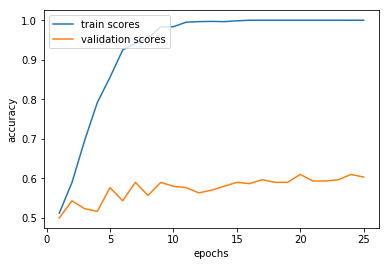

In [11]:
plt.xlabel('epochs')
plt.ylabel('accuracy')

e = np.arange(1, epochs + 1)
plt.plot(e,epoch_train_scores)
plt.plot(e,epoch_test_scores)
plt.legend(['train scores', 'validation scores'], loc='upper left')


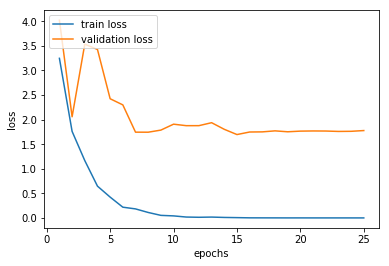

In [12]:
plt.xlabel('epochs')
plt.ylabel('loss')

e = np.arange(1, epochs + 1)
plt.plot(e,epoch_train_losses)
plt.plot(e,epoch_test_losses)
plt.legend(['train loss', 'validation loss'], loc='upper left')

In [13]:
torch.cuda.empty_cache()

In [15]:
# Computing number of trainable parameters in the model
model_parameters = filter(lambda p: p.requires_grad, cnn3d.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

14555140


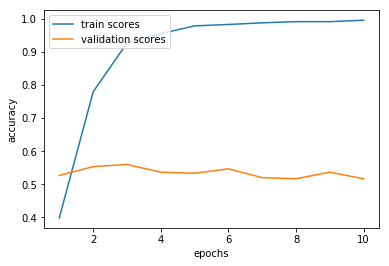

In [12]:
plt.xlabel('epochs')
plt.ylabel('accuracy')

e = np.arange(1, epochs + 1)
plt.plot(e,epoch_train_scores)
plt.plot(e,epoch_test_scores)
plt.legend(['train scores', 'validation scores'], loc='upper left')

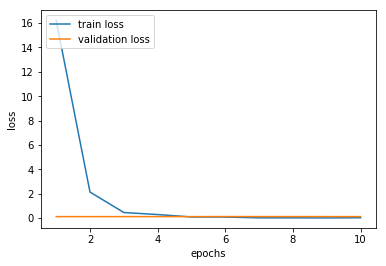

In [11]:
plt.xlabel('epochs')
plt.ylabel('loss')

e = np.arange(1, epochs + 1)
plt.plot(e,epoch_train_losses)
plt.plot(e,epoch_test_losses)
plt.legend(['train loss', 'validation loss'], loc='upper left')

In [11]:
cnn3d = resnet10()
print(cnn3d)

/home/chinmay/code/Resnet.py:110: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


ResNet(
  (conv1): Conv3d(10, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(2, 2, 2), padding=(0, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv3d(128, 128, kernel_size=(1, 3, 3), st